In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster
import os
from typing import List, Dict, Any, Optional, Union, Tuple

In [98]:
def cargar_pozos_csv(ruta_archivo: str) -> pd.DataFrame:
    """
    Carga un archivo CSV con información de pozos y devuelve un DataFrame.
    
    Args:
        ruta_archivo (str): Ruta al archivo CSV
    
    Returns:
        pd.DataFrame: DataFrame con los datos de pozos
    """
    try:
        # Cargar el CSV
        df = pd.read_csv(ruta_archivo, sep=";", na_values="NaN")
        df.dropna(subset=['X', 'Y'], inplace=True)  # Eliminar filas sin coordenadas
        df.dropna(inplace=True)  # Eliminar filas con cualquier NaN
        
        # Verificar columnas esenciales
        columnas_requeridas = ['X', 'Y', 'PROFUNDIDAD_TOTAL', 'DATUM']
        columnas_faltantes = [col for col in columnas_requeridas if col not in df.columns]
        
        if columnas_faltantes:
            print(f"Advertencia: Faltan las siguientes columnas: {', '.join(columnas_faltantes)}")
        
        print(f"Se cargaron {len(df)} registros de pozos.")
        return df
    
    except Exception as e:
        print(f"Error al cargar el archivo: {e}")
        return pd.DataFrame()

In [99]:
def convertir_a_geodataframe(df: pd.DataFrame, 
                           col_x: str = 'X', 
                           col_y: str = 'Y', 
                           crs_origen: str = 'EPSG:5348') -> gpd.GeoDataFrame:
    """
    Convierte un DataFrame de pandas a GeoDataFrame utilizando coordenadas X,Y
    
    Args:
        df (pd.DataFrame): DataFrame con los datos de pozos
        col_x (str): Nombre de la columna con coordenadas X
        col_y (str): Nombre de la columna con coordenadas Y
        crs_origen (str): Sistema de coordenadas de referencia (CRS) de origen
                          EPSG:5348 corresponde a POSGAR 2007 / Argentina zona 3
    
    Returns:
        gpd.GeoDataFrame: GeoDataFrame con geometría
    """
    # Verificar que las columnas X e Y existan
    if col_x not in df.columns or col_y not in df.columns:
        print(f"Error: Columnas {col_x} y/o {col_y} no encontradas en el DataFrame")
        return gpd.GeoDataFrame()
    
    # Crear geometría a partir de coordenadas X,Y
    geometry = [Point(xy) for xy in zip(df[col_x], df[col_y])]
    
    # Crear GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs_origen)
    
    return gdf

In [100]:
def filtrar_pozos(df: pd.DataFrame, filtros: Dict[str, Any]) -> pd.DataFrame:
    """
    Filtra el DataFrame de pozos según los criterios especificados
    
    Args:
        df (pd.DataFrame): DataFrame con datos de pozos
        filtros (Dict[str, Any]): Diccionario con los filtros a aplicar
            Ejemplos: 
            - {'yacimiento': 'Loma La Lata'}
            - {'bloque': 'LLL', 'tipo_pozo': 'Productor'}
            - {'profundidad_final': {'min': 2000, 'max': 3500}}
    
    Returns:
        pd.DataFrame: DataFrame filtrado
    """
    df_filtrado = df.copy()
    
    for campo, valor in filtros.items():
        # Si el campo existe en el DataFrame
        if campo in df.columns:
            # Si el valor es un diccionario con 'min' y 'max' para rangos numéricos
            if isinstance(valor, dict) and ('min' in valor or 'max' in valor):
                if 'min' in valor:
                    df_filtrado = df_filtrado[df_filtrado[campo] >= valor['min']]
                if 'max' in valor:
                    df_filtrado = df_filtrado[df_filtrado[campo] <= valor['max']]
            # Para valores exactos
            else:
                df_filtrado = df_filtrado[df_filtrado[campo] == valor]
        else:
            print(f"Advertencia: El campo '{campo}' no existe en el DataFrame")
    
    print(f"Se encontraron {len(df_filtrado)} pozos que cumplen con los criterios de filtrado")
    return df_filtrado

In [101]:
def crear_mapa_pozos(gdf: gpd.GeoDataFrame, 
                   campo_color: Optional[str] = None,
                   campo_tamanio: Optional[str] = None,
                   titulo: str = 'Mapa de Pozos',
                   guardar_como: Optional[str] = None,
                   crs_destino: str = 'EPSG:4326',
                   crs_origen: str = 'EPSG:22183',  # Campo Inchauspe / Argentina zona 3
                   verificar_coordenadas: bool = True,
                   agregar_basemap: bool = True,
                   allow_override: bool = True) -> plt.Figure:
    """
    Crea un mapa estático de pozos utilizando matplotlib
    
    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame con los pozos
        campo_color (str, opcional): Campo para colorear los pozos
        campo_tamanio (str, opcional): Campo para ajustar el tamaño de los pozos
        titulo (str): Título del mapa
        guardar_como (str, opcional): Ruta donde guardar el mapa
        crs_destino (str): Sistema de coordenadas para visualización (WGS84)
        crs_origen (str): Sistema de coordenadas de origen 
                          (por defecto Campo Inchauspe / Argentina zona 3)
        verificar_coordenadas (bool): Si es True, verifica y corrige posibles problemas
        agregar_basemap (bool): Si es True, agrega un mapa base contextual
        allow_override (bool): Si es True, permite sobrescribir el CRS existente
    
    Returns:
        plt.Figure: Figura de matplotlib con el mapa
    """
    # Verificar que el GeoDataFrame tiene geometría
    if not isinstance(gdf, gpd.GeoDataFrame) or gdf.geometry.is_empty.all():
        print("Error: El GeoDataFrame no tiene geometrías válidas")
        return None
    
    # Hacer una copia para no modificar el original
    gdf_copy = gdf.copy()
    
    # Asegurar que el CRS está correctamente establecido
    if gdf_copy.crs is None:
        print(f"Advertencia: CRS no definido. Asignando {crs_origen}")
        gdf_copy.set_crs(crs_origen, inplace=True, allow_override=allow_override)
    
    # Verificar el tipo de coordenadas y hacer correcciones si es necesario
    if verificar_coordenadas:
        # Extraer coordenadas X e Y para análisis
        coords_x = [geom.x for geom in gdf_copy.geometry]
        coords_y = [geom.y for geom in gdf_copy.geometry]
        
        # Determinar si son coordenadas Gauss-Krueger de Argentina (Campo Inchauspe o POSGAR)
        # Ajustado para aceptar X en el rango 2.4-2.6 millones y Y en 4.8-4.9 millones
        x_es_gauss_krueger = all(2400000 <= x <= 2600000 for x in coords_x if x is not None)
        y_es_gauss_krueger = all(4800000 <= y <= 5000000 for y in coords_y if y is not None)
        
        # En WGS84, las coordenadas para Argentina están en rangos aproximados:
        # Longitud (X): -75 a -52
        # Latitud (Y): -55 a -21
        x_es_wgs84 = all(-75 <= x <= -52 for x in coords_x if x is not None)
        y_es_wgs84 = all(-55 <= y <= -21 for y in coords_y if y is not None)
        
        # Determinar transformación necesaria basada en análisis
        if x_es_gauss_krueger and y_es_gauss_krueger:
            # Son coordenadas Gauss-Krueger, proceder con la transformación
            print("Detectadas coordenadas Gauss-Krueger (Campo Inchauspe/POSGAR). Transformando a WGS84...")
            if gdf_copy.crs != crs_origen:
                print(f"Actualizando CRS a {crs_origen}")
                gdf_copy.set_crs(crs_origen, inplace=True, allow_override=allow_override)
            
            try:
                gdf_plot = gdf_copy.to_crs(crs_destino)
            except Exception as e:
                print(f"Error en transformación: {e}")
                print("Intentando corregir usando 'allow_override=True'...")
                gdf_copy.set_crs(crs_origen, inplace=True, allow_override=True)
                gdf_plot = gdf_copy.to_crs(crs_destino)
            
            # Verificación post-transformación
            test_coords_x = [geom.x for geom in gdf_plot.geometry]
            test_coords_y = [geom.y for geom in gdf_plot.geometry]
            
            # Verificar que las coordenadas transformadas están en el rango esperado para Argentina
            x_ok = all(-75 <= x <= -52 for x in test_coords_x if x is not None)
            y_ok = all(-55 <= y <= -21 for y in test_coords_y if y is not None)
            
            if not (x_ok and y_ok):
                print("Advertencia: La transformación no produjo coordenadas WGS84 válidas para Argentina.")
                print(f"X transformada: min={min(test_coords_x)}, max={max(test_coords_x)}")
                print(f"Y transformada: min={min(test_coords_y)}, max={max(test_coords_y)}")
                
                # Probar con sistemas alternativos de coordenadas para Argentina
                sistemas_alternativos = [
                    'EPSG:22173',  # Campo Inchauspe faja 3 
                    'EPSG:22181',  # Campo Inchauspe / Argentina 1
                    'EPSG:22182',  # Campo Inchauspe / Argentina 2
                    'EPSG:22183',  # Campo Inchauspe / Argentina 3
                    'EPSG:22184',  # Campo Inchauspe / Argentina 4
                    'EPSG:22185',  # Campo Inchauspe / Argentina 5
                    'EPSG:22186',  # Campo Inchauspe / Argentina 6
                    'EPSG:22187',  # Campo Inchauspe / Argentina 7
                    'EPSG:5343',   # POSGAR 2007 / Argentina 1
                    'EPSG:5344',   # POSGAR 2007 / Argentina 2
                    'EPSG:5345',   # POSGAR 2007 / Argentina 3
                    'EPSG:5346',   # POSGAR 2007 / Argentina 4
                    'EPSG:5347',   # POSGAR 2007 / Argentina 5
                    'EPSG:5348',   # POSGAR 2007 / Argentina 6
                    'EPSG:5349',   # POSGAR 2007 / Argentina 7
                ]
                
                # Probar cada sistema y quedarse con el que produzca coordenadas en el rango esperado
                for sistema in sistemas_alternativos:
                    if sistema == crs_origen:
                        continue  # Saltamos el que ya probamos
                        
                    print(f"Probando con {sistema}...")
                    try:
                        gdf_copy.set_crs(sistema, inplace=True, allow_override=True)
                        gdf_test = gdf_copy.to_crs(crs_destino)
                        
                        test_x = [geom.x for geom in gdf_test.geometry]
                        test_y = [geom.y for geom in gdf_test.geometry]
                        
                        x_ok = all(-75 <= x <= -52 for x in test_x if x is not None)
                        y_ok = all(-55 <= y <= -21 for y in test_y if y is not None)
                        
                        if x_ok and y_ok:
                            print(f"¡Éxito! {sistema} produjo coordenadas válidas.")
                            gdf_plot = gdf_test
                            break
                    except Exception as e:
                        print(f"Error al probar {sistema}: {e}")
                    
                    # Restaurar el CRS original para el próximo intento
                    gdf_copy.set_crs(crs_origen, inplace=True, allow_override=True)
        elif x_es_wgs84 and y_es_wgs84:
            # Ya son coordenadas WGS84, no necesitan transformación
            print("Detectadas coordenadas WGS84. No es necesaria transformación.")
            gdf_copy.set_crs(crs_destino, inplace=True, allow_override=allow_override)
            gdf_plot = gdf_copy
        else:
            # Coordenadas ambiguas - intentar transformación estándar
            print("Advertencia: Coordenadas ambiguas. Intentando transformación estándar.")
            if gdf_copy.crs != crs_origen:
                gdf_copy.set_crs(crs_origen, inplace=True, allow_override=allow_override)
            
            try:
                gdf_plot = gdf_copy.to_crs(crs_destino)
            except Exception as e:
                print(f"Error en transformación estándar: {e}")
                print("Intentando usar directamente las coordenadas originales...")
                # En caso de error, usar directamente las coordenadas originales
                gdf_plot = gdf_copy
    else:
        # No verificar, simplemente transformar según el CRS
        if gdf_copy.crs != crs_destino:
            try:
                gdf_plot = gdf_copy.to_crs(crs_destino)
            except Exception as e:
                print(f"Error en transformación: {e}")
                print("Intentando corregir usando 'allow_override=True'...")
                gdf_copy.set_crs(crs_origen, inplace=True, allow_override=True)
                gdf_plot = gdf_copy.to_crs(crs_destino)
        else:
            gdf_plot = gdf_copy
    
    # Crear la figura
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Definir parámetros del scatter plot
    plot_kwargs = {'marker': 'o', 'alpha': 0.7}
    
    # Si se proporciona campo de color
    if campo_color and campo_color in gdf_plot.columns:
        plot_kwargs['column'] = campo_color
        plot_kwargs['legend'] = True
    
    # Si se proporciona campo de tamaño
    if campo_tamanio and campo_tamanio in gdf_plot.columns:
        # Normalizar el tamaño
        min_size = 20
        max_size = 200
        sizes = gdf_plot[campo_tamanio]
        if sizes.max() > sizes.min():  # Evitar división por cero
            sizes_norm = min_size + (sizes - sizes.min()) * (max_size - min_size) / (sizes.max() - sizes.min())
            plot_kwargs['markersize'] = sizes_norm
    
    # Crear el mapa
    gdf_plot.plot(ax=ax, **plot_kwargs)
    
    # Intentar agregar un mapa base si se solicita
    if agregar_basemap:
        try:
            import contextily as ctx
            ctx.add_basemap(ax, crs=gdf_plot.crs, source=ctx.providers.CartoDB.Positron)
            print("Mapa base agregado correctamente")
        except Exception as e:
            print(f"No se pudo agregar mapa base: {e}")
            print("Para agregar mapas base, instale contextily: pip install contextily")
    
    # Añadir título y referencias
    plt.title(titulo, fontsize=16)
    plt.grid(True)
    
    # Guardar la figura si se proporciona una ruta
    if guardar_como:
        plt.savefig(guardar_como, dpi=300, bbox_inches='tight')
        print(f"Mapa guardado como: {guardar_como}")
    
    return fig

In [102]:
def exportar_filtro(df: pd.DataFrame, 
                  columnas: List[str] = None, 
                  ruta_archivo: str = 'pozos_filtrados.csv') -> None:
    """
    Exporta el DataFrame filtrado a un archivo CSV
    
    Args:
        df (pd.DataFrame): DataFrame con los pozos filtrados
        columnas (List[str], opcional): Columnas a incluir en la exportación
        ruta_archivo (str): Ruta donde guardar el archivo CSV
    """
    # Si no se especifican columnas, exportar todas
    if columnas:
        df_export = df[columnas].copy()
    else:
        df_export = df.copy()
    
    # Si es un GeoDataFrame, eliminamos la columna de geometría para CSV
    if isinstance(df, gpd.GeoDataFrame) and 'geometry' in df_export.columns:
        df_export = pd.DataFrame(df_export.drop(columns=['geometry']))
    
    # Exportar a CSV
    df_export.to_csv(ruta_archivo, index=False, encoding='utf-8')
    print(f"Datos exportados a: {ruta_archivo}")
    print(f"Se exportaron {len(df_export)} registros con {len(df_export.columns)} campos")

In [103]:
# Ejemplo de uso completo
def ejemplo_flujo_trabajo():
    """
    Ejemplo de un flujo de trabajo completo utilizando todas las funciones
    """
    # 1. Cargar datos
    ruta_csv = "pruebapozos.csv"
    df_pozos = cargar_pozos_csv(ruta_csv)
    
    # 2. Convertir a GeoDataFrame
    gdf_pozos = convertir_a_geodataframe(df_pozos)
    
    # Para revisar las coordenadas originales
    for idx, geom in enumerate(gdf_pozos.geometry[:5]):  # Primeras 5 filas
        print(f"Pozo {idx}: X={geom.x}, Y={geom.y}")
    
    # 3. Aplicar filtros
    filtros = {
        'ESTADO': 'EEF'
    }
    pozos_filtrados = filtrar_pozos(gdf_pozos, filtros)
    
    # 4. Crear mapa estático
    fig = crear_mapa_pozos(
        pozos_filtrados, 
        campo_color='ESTADO', 
        campo_tamanio='PROFUNDIDAD_TOTAL',
        titulo='Pozos Productores en EL Guadal',
        guardar_como='mapa_pozos_lll.png'
    )
    
    
    # 6. Exportar filtro para otros análisis
    exportar_filtro(
        pozos_filtrados,
        columnas=['IDENTIFICADOR', 'X', 'Y', 'PROFUNDIDAD_TOTAL', 'YACIMIENTO', 'ESTADO'],
        ruta_archivo='pozos_filtrados_para_analisis.csv'
    )
    
    print("Proceso completo finalizado.")

In [104]:
# Si este script se ejecuta directamente
if __name__ == "__main__":
    print("Biblioteca de funciones para procesamiento de datos de pozos petroleros")
    print("Importa estas funciones en tu script o ejecuta ejemplo_flujo_trabajo() para ver un ejemplo")

Biblioteca de funciones para procesamiento de datos de pozos petroleros
Importa estas funciones en tu script o ejecuta ejemplo_flujo_trabajo() para ver un ejemplo


Se cargaron 5 registros de pozos.
Pozo 0: X=2489970.0, Y=4904639.0
Pozo 1: X=2499975.0, Y=4850063.0
Pozo 2: X=2499855.0, Y=4854394.0
Pozo 3: X=2499984.0, Y=4854920.0
Pozo 4: X=2499821.0, Y=4854643.0
Se encontraron 4 pozos que cumplen con los criterios de filtrado
Detectadas coordenadas Gauss-Krueger (Campo Inchauspe/POSGAR). Transformando a WGS84...
Actualizando CRS a EPSG:22183
Advertencia: La transformación no produjo coordenadas WGS84 válidas para Argentina.
X transformada: min=-78.8744963744909, max=-78.85321452799799
Y transformada: min=-45.77253585737379, max=-45.27953415192151
Probando con EPSG:22173...
Probando con EPSG:22181...
¡Éxito! EPSG:22181 produjo coordenadas válidas.
Mapa base agregado correctamente
Mapa guardado como: mapa_pozos_lll.png
Datos exportados a: pozos_filtrados_para_analisis.csv
Se exportaron 4 registros con 6 campos
Proceso completo finalizado.


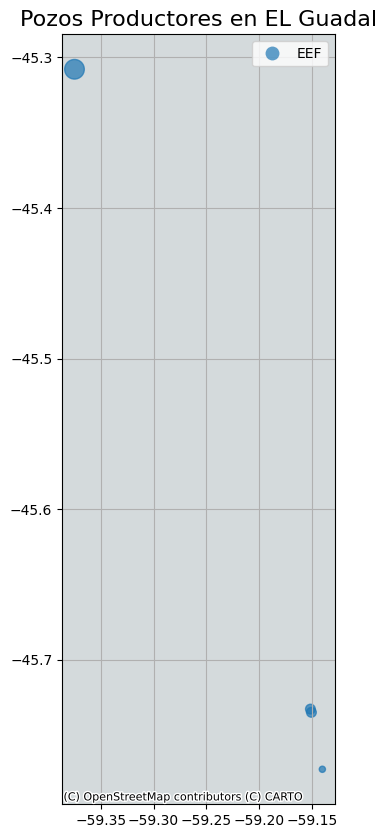

In [105]:
ejemplo_flujo_trabajo()

In [43]:
df = pd.read_csv("pruebapozos.csv", sep=";", na_values="NaN")
df.dropna(subset=['X', 'Y'], inplace=True)  # Eliminar filas sin coordenadas
df.dropna(inplace=True)  # Eliminar filas con cualquier NaN
df

,IDENTIFICADOR,UWI,NOMBRE_COMPLETO,ALIAS,X,Y,DATUM,FCOMP,PROFUNDIDAD_TOTAL,ESTADO,YACIMIENTO
0,Hue.xp-10,11111,YPF.SC.Hue.xp-10,Hue.xp-10,2489970,4904639,425.0,12/2/1996,2268.00,EEF,LOS PERALES
2,CG.a-8,11113,YPF.SC.CG.a-8,CG.a-8,2499975,4850063,370.0,19/8/1973,892.42,EEF,LOMAS DEL CUY
3,CG-16,11114,YPF.SC.CG-16,CG-16,2499855,4854394,360.0,7/5/1997,1118.58,EEF,LOMAS DEL CUY
4,CG-17,11115,YPF.SC.CG-17,CG-17,2499984,4854920,360.0,8/11/1997,1136.54,EIE,LOMAS DEL CUY
5,CG-26,11116,YPF.SC.CG-26,CG-26,2499821,4854643,363.0,9/11/1997,1114.98,EEF,LOMAS DEL CUY


In [ ]:
# Para revisar las coordenadas originales
for idx, geom in enumerate(gdf_pozos.geometry[:5]):  # Primeras 5 filas
    print(f"Pozo {idx}: X={geom.x}, Y={geom.y}")